# 1. Project Topic 7

Authors: 
* Philipp Bonny (3761754)
* Benjamin Jung (3761649)
* Peter Klein (3761266)

## 1.1 Data

The data for this project comes from New York Stock Exchange. The dataset was originally released
on Kaggle and, among other information, contains several years of daily stock prices for S&P 500
companies. The dataset is available from Moodle. For more detailed information about it, please
refer to its original description on Kaggle.

## 1.2 Goal

The goal of this project is to predict the price of a stock for the next day, one week into the future, or one month into the future. This is a problem for which many traditional time-series analysis methods
exist (e.g., exponential smoothing), but which can also be addressed using recurrent neural
networks (e.g., LSTMs or GRUs).

## 1.3 Ideas and Suggestions

* First, you need to familiarize yourself with the dataset and make sure that you understand the
different values in it and its particularities.

* Second, you should identify suitable baseline methods. These include traditional time-series
analysis methods (e.g., exponential smoothing and time-series decomposition). Note that you
do not have to implement those yourselves, but you can rely on existing implementations.
Also, consider having a look at Prophet as a general-purpose time-series prediction library
developed at facebook.

* Third, you should think about your own approach(es). One idea is to apply a form of recurrent
neural network (e.g., LSTM or GRU) to a time series in isolation, viewing it as a sequence of
numerical values. As a variant, you may consider taking additional information (e.g., the time
series belonging to other stocks) into account. The goal should always be to predict the price
of an individual stock, but you can vary how much additional information you consider.

* For the evaluation, you should compare the different approaches in terms of a suitable quality
measure (e.g., mean absolute error), consider different time periods, and vary how much historical data is taken into account.

## 1.4 Introduction 
In this project, we want to find out whether the stock prices of a company in the S&P 500 can be predicted using various methods. In order to compare the different methods, we will make predictions 30 days into the future and compare the results using the mean squared error.

The following methods will be compared:

* Simple Exponential Smoothing (SES)
* Facebook Prophet
* Recurrent Neural Network
    * Gated Recurrent Unit (GRU)
    * Long short-term memory (LSTM)
        * One Layer LSTM
        * Multi Layer LSTM
        * Multi Layer LSTM with multiple Data Columns


# 2. Import Libraries
In this section the required libraries are imported.

In [1]:
import os
import pandas as pd

# We need to use numpy=1.19 to be compatible with tensorflow version
import numpy as np

# Plot Graphs
import matplotlib.pyplot as plt

# Calculate Dates
import datetime
import matplotlib.dates as mdates

# We use the sklearn lib to split the data into test/train data
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Simple Exponential Smoothing (SES)
from statsmodels.tsa.api import SimpleExpSmoothing 

# Facebook Prophet
from prophet import Prophet
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
from prophet.plot import plot_cross_validation_metric

# RNN
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, LSTM, Dropout, SimpleRNN, GRU
print(tf.__version__)

# Deactivate GPU usage by tensorflow because CPU is faster in our cases
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

Importing plotly failed. Interactive plots will not work.


2.3.0


# 3. Configurations
* ticker_name defines the name of the stock that should be trained and predicted on 

In [2]:
ticker_name = 'AAPL'

# 4. Predefined Functions
Some of the plot functions that are used more than once have been placed in this separate area.

In [3]:
def plot_graph(title, actual_date_df, actual_value_df):
    fig = plt.figure(figsize = (10,6))
    ax1 = fig.add_axes([0,0,1,1])
    ax1.set_title(title)

    ax1.plot(actual_date_df, actual_value_df, color='green')

    ax1.set_ylabel('Price')
    ax1.set_xlabel('Year')
    plt.show()
    return

def plot_comparison_graph(title, actual_date_df, actual_value_df, predicted_date_df, predicted_value_df):
    fig = plt.figure(figsize = (10,6))
    ax1 = fig.add_axes([0,0,1,1])
    ax1.set_title(title)

    actual_date_df_converted = pd.to_datetime(actual_date_df, format = '%Y-%m-%d')
    predicted_date_df_converted = pd.to_datetime(predicted_date_df, format = '%Y-%m-%d')
    
    ax1.plot(actual_date_df, actual_value_df, color='green', label='Actual')
    ax1.plot(predicted_date_df,predicted_value_df, color='red', label='Predicted')

    ax1.set_ylabel('Price')
    ax1.set_xlabel('Year')
    plt.legend()
    plt.show()
    return
    
def show_comparison_plot(plot_data, delta, title):
    labels = ["History", "True Future", "Model Prediction"]
    marker = [".-", "rx", "go"]
    time_steps = list(range(-(plot_data[0].shape[0]), 0))
    if delta:
        future = delta
    else:
        future = 0

    plt.title(title)
    for i, val in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=10, label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
    plt.legend()
    plt.xlim([time_steps[0], (future + 5) * 2])
    plt.xlabel("Time-Step")
    plt.show()
    return

def visualize_loss(history, title):
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs = range(len(loss))
    plt.figure()
    plt.plot(epochs, loss, "b", label="Training loss")
    plt.plot(epochs, val_loss, "r", label="Validation loss")
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()
    return

In [4]:
def getStockData(path):
    # Read complete csv file of stocks
    sp500 = pd.read_csv(path) 

    # Filter dataframe by ticker_name
    df = sp500[sp500['symbol'] == ticker_name].copy(deep=False)

    # Convert Date to panda DateTime
    df['date'] = pd.to_datetime(df['date'], format = '%Y-%m-%d')

    return df

In [5]:
# Fucntion to predict data with prophet
def predict_prophet(prophet_data, days_to_predict):
    # Grap stock data to predict a month in the future
    train = prophet_data.drop(prophet_data.index[-days_to_predict:])
    init_test = prophet_data[-days_to_predict:]

    # Future defines the days/dates that will be predicted
    future = pd.DataFrame(init_test['ds'])

    # Start training the model with the testdata
    model = Prophet(daily_seasonality=False)
    model.fit(train)

    # make a prediction with the testdata for the last 31 days of data we have
    prophet_prediction = model.predict(future)
    return init_test, prophet_prediction

# 5. Data selection

The following data was available:

## 5.1 securities.csv
The data in the securities.csv file provides information about the industry sector in which the respective companies are located and when they were listed on the stock exchange. However, as we will only be looking at one individual share in the following, we have not made any further use of the data provided here.

## 5.2 fundamentals.csv
The fundamentals.csv file provides insights into the annual reports of various companies. Profits and losses can be derived from them. However, this data set was not used in our project either, because the data sets are not complete. For example, for the Apple share, data is only available for the years 2013 to 2016. However, since we are looking at a period from 2010 to the beginning of 2017 and here we are only acting within the last 30 days of the data set, we did not use the fundamental data of the companies.


## 5.3 prices.csv & prices-split-adjusted.csv

The files prices.csv & prices-split-adjusted.csv contain the historical price data of numerous companies from the S&P 500 index. There is a corresponding entry for each trading day. From this, information such as the opening, closing, high and low price as well as the trading volume on this day can be obtained.

The difference between both datasets is that in the prices.csv file no consideration is given to stock splits. This means, for example, that the price of the Apple share in 2014 was changed accordingly due to a stock split. This is not a natural price change that has to be predicted by a system. Accordingly, we use the price data from the file prices-split-adjusted.csv. Here, according to the stock split, all prices were calculated relatively and thus an adjusted price history was created.

In the following you can see the course once adjusted and once original.

## 5.4 Comparison prices.csv & prices-split-adjusted.csv

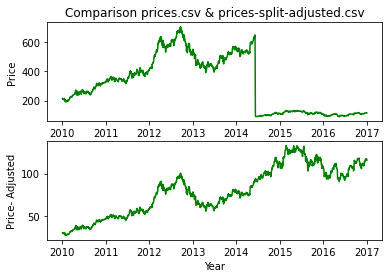

In [6]:
not_adjusted_df = getStockData('data/prices.csv')
adjusted_df = getStockData('data/prices-split-adjusted.csv')

plt.subplot(2, 1, 1)
plt.plot(not_adjusted_df["date"], not_adjusted_df["close"], color='green')
plt.title('Comparison prices.csv & prices-split-adjusted.csv')
plt.ylabel('Price')


plt.subplot(2, 1, 2)
plt.plot(adjusted_df["date"], adjusted_df["close"], color='green')
plt.xlabel('Year')
plt.ylabel('Price- Adjusted')

plt.show()

# 6. Read Stock Data

First, we will read the existing stock prices of the S&P500 index from the csv file into a dataframe. We will use the adjusted price history. This takes into account dividends, stock splits and other factors that may have affected the price.

We create two datframes from the dataset. One is the dataframe stock_df_date_close which contains only the date and the daily closing price and the other is the dataframe stock_df_complete which contains all columns except the symbol. The former is used for the primitive approaches, while the complete data columns are additionally used later in a neural network.

In [7]:
stock_df = getStockData('data/prices-split-adjusted.csv')
stock_df

,date,symbol,open,close,low,high,volume
254,2010-01-04,AAPL,30.490000,30.572857,30.340000,30.642857,123432400.0
721,2010-01-05,AAPL,30.657143,30.625713,30.464285,30.798571,150476200.0
1189,2010-01-06,AAPL,30.625713,30.138571,30.107143,30.747143,138040000.0
1657,2010-01-07,AAPL,30.250000,30.082857,29.864286,30.285715,119282800.0
2125,2010-01-08,AAPL,30.042856,30.282858,29.865715,30.285715,111902700.0
...,...,...,...,...,...,...,...
848767,2016-12-23,AAPL,115.589996,116.519997,115.589996,116.519997,14249500.0
849267,2016-12-27,AAPL,116.519997,117.260002,116.489998,117.800003,18296900.0
849767,2016-12-28,AAPL,117.519997,116.760002,116.199997,118.019997,20905900.0
850267,2016-12-29,AAPL,116.449997,116.730003,116.400002,117.110001,15039500.0


## 6.1 Prepare the Data

In [8]:
# We prepare the dataframe so we can use it for training
# therefore we select the Date and Closing Price
stock_df_date_close = stock_df[["date", "close"]]
stock_df_complete = stock_df[["date", "close", "open", "low", "high", "volume"]]
stock_df_date_close

,date,close
254,2010-01-04,30.572857
721,2010-01-05,30.625713
1189,2010-01-06,30.138571
1657,2010-01-07,30.082857
2125,2010-01-08,30.282858
...,...,...
848767,2016-12-23,116.519997
849267,2016-12-27,117.260002
849767,2016-12-28,116.760002
850267,2016-12-29,116.730003


## 6.2 History Stock Price

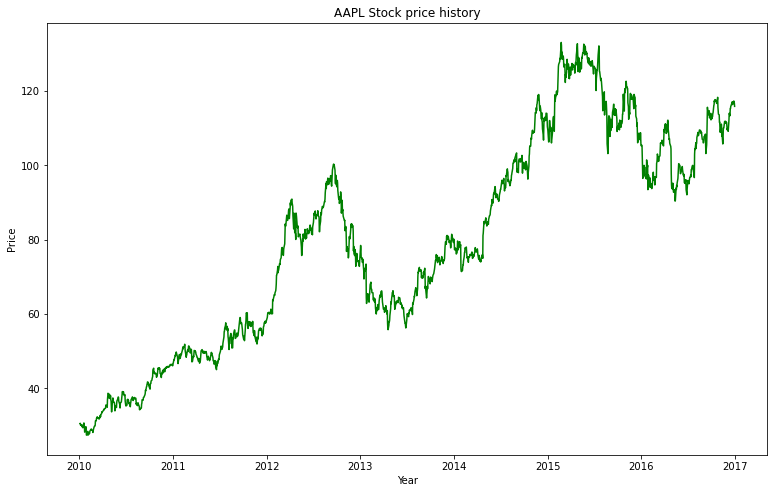

In [9]:
plot_graph(ticker_name + ' Stock price history', stock_df['date'], stock_df['close'])

# 7. Simple Exponential Smoothing (SES)

As our first approach we will use time series forecasting using Simple Exponential Smoothing. 
First, we fill our dataset with missing data. For Simple Exponential Smoothing we need a complete data set. Since we are dealing with stock prices and the stock exchange is only open on working days, weekends and holidays are missing. For this we use the function .ffill() which uses the data of the previous entry to fill the gaps before. This is generally correct, because the share price usually does not change over the weekend, for example. Thus we do not falsify any data.

Simple Exponential Smoothing works with weighted averages. We can influence these by determining an alpha value. The value lies between 0 and 1. We have performed a run with a self-defined value of 0.1 and a run in which the system determined the alpha value itself.

In this first experiment, we used the entire data set to train and test the prediction on the last 30 days that we know. Our prediction with an alpha value of 0.1 has surprisingly a lower mean squared error than the optimized value of the system itself and was able to predict the future price better. 


## 7.1 SES Training with complete Dataset

In [10]:
ses_data = stock_df_date_close.copy(deep=False)
ses_data.columns = ['ds','y']

ses_data_fitted = pd.Series(ses_data['y'].values, ses_data['ds'].values)

# Fill missing dates for SES (weekends while stock market is closed)
ses_data_fitted = ses_data_fitted.resample('D').ffill()

# We need to set the index frequency
ses_data_fitted.index = pd.DatetimeIndex(ses_data_fitted.index).to_period('D')

# Split the data so we compare the prediction against the actual value
# Grap stock data to predict a month in the future
ses_train = ses_data_fitted.drop(ses_data_fitted.index[-30:])
ses_train_small = ses_train[-30:]
ses_test = ses_data_fitted[-30:]

D:\Software\anaconda3\envs\tf\lib\site-packages\statsmodels\tsa\holtwinters\model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(
D:\Software\anaconda3\envs\tf\lib\site-packages\statsmodels\tsa\holtwinters\model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


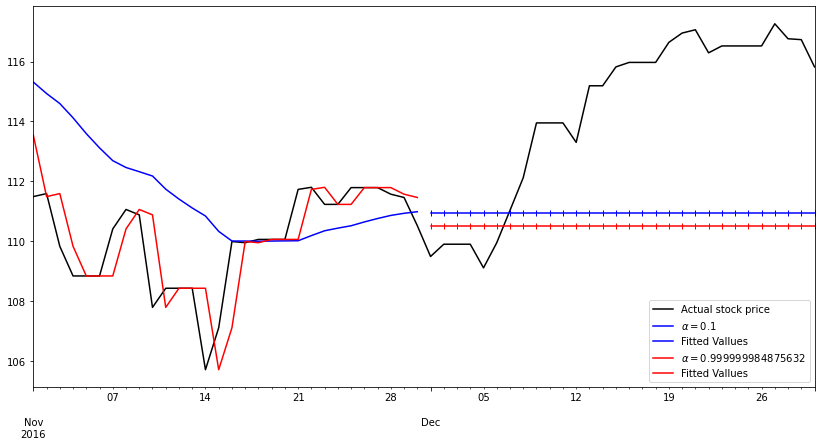

MSE with α=0.1 is: 19.012
MSE with α=0.999999984875632 is: 22.036


In [45]:
ses_data_fitted[-60:].plot(color='black', legend=True, figsize=(14, 7), label="Actual stock price") 
    
ses_fit_1 = SimpleExpSmoothing(ses_train).fit(smoothing_level=0.1,optimized=False)
predict_fit_1 = ses_fit_1.predict(ses_test.index.min(), ses_test.index.max()).rename(r'$\alpha={}$'.format(0.1))

# specific smoothing level
predict_fit_1.plot(marker="|",  color='blue', legend=True)
ses_fit_1.fittedvalues[-30:].plot(color='blue', legend=True, label="Fitted Vallues")

## auto optimization
ses_fit_2 = SimpleExpSmoothing(ses_train).fit()
predict_fit_2 = ses_fit_2.predict(ses_test.index.min(), ses_test.index.max()).rename(r'$\alpha=%s$'%ses_fit_2.model.params['smoothing_level'])

# plot
predict_fit_2.plot(marker="|", color='red', legend=True)
ses_fit_2.fittedvalues[-30:].plot(color='red', legend=True, label="Fitted Vallues")
plt.show()

mse_sse_complete = mean_squared_error(ses_test.values, predict_fit_1.values)
print('MSE with \u03B1=0.1 is: %.3f' % mse_sse_complete)

mse2 = mean_squared_error(ses_test.values, predict_fit_2.values)
print('MSE with \u03B1=%s is: %.3f' % (ses_fit_2.model.params['smoothing_level'] , mse2))

## 7.2 SES Training with small Dataset

To test the behavior of Simple Exponential Smoothing with different data sets, we run the same prediction with a much smaller training data set containing only 30 trading days. We see that the prediction of the alpha value optimized by the system has hardly changed and the prediction has remained the same. Only our low alpha value of 0.1 generated a worse performance.

D:\Software\anaconda3\envs\tf\lib\site-packages\statsmodels\tsa\holtwinters\model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(
D:\Software\anaconda3\envs\tf\lib\site-packages\statsmodels\tsa\holtwinters\model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


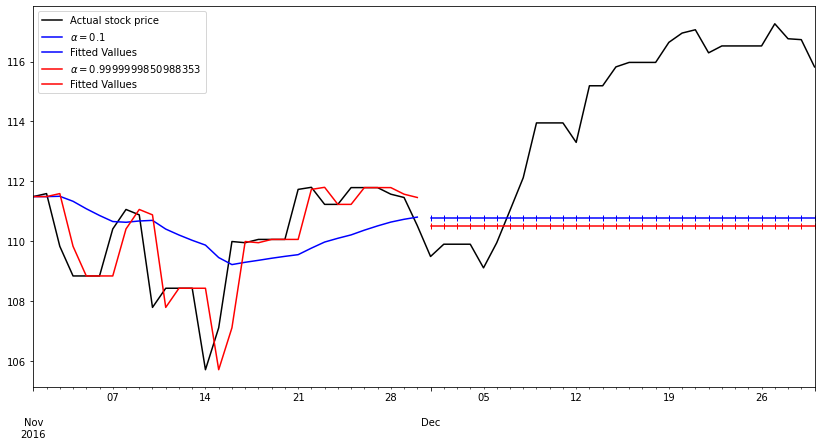

MSE with α=0.1 is: 20.142
MSE with α=0.9999999850988353 is: 22.036


In [46]:
ses_data_fitted[-60:].plot(color='black', legend=True, figsize=(14, 7), label="Actual stock price") 
    
ses_fit_1 = SimpleExpSmoothing(ses_train_small).fit(smoothing_level=0.1,optimized=False)
predict_fit_1 = ses_fit_1.predict(ses_test.index.min(), ses_test.index.max()).rename(r'$\alpha={}$'.format(0.1))

# specific smoothing level
predict_fit_1.plot(marker="|",  color='blue', legend=True)
ses_fit_1.fittedvalues[-30:].plot(color='blue', legend=True, label="Fitted Vallues")

## auto optimization
ses_fit_2 = SimpleExpSmoothing(ses_train_small).fit()
predict_fit_2 = ses_fit_2.predict(ses_test.index.min(), ses_test.index.max()).rename(r'$\alpha=%s$'%ses_fit_2.model.params['smoothing_level'])

# plot
predict_fit_2.plot(marker="|", color='red', legend=True)
ses_fit_2.fittedvalues[-30:].plot(color='red', legend=True, label="Fitted Vallues")
plt.show()

mse_sse_partly = mean_squared_error(ses_test.values, predict_fit_1.values)
print('MSE with \u03B1=0.1 is: %.3f' % mse_sse_partly)

mse2 = mean_squared_error(ses_test.values, predict_fit_2.values)
print('MSE with \u03B1=%s is: %.3f' % (ses_fit_2.model.params['smoothing_level'] , mse2))

# 8. Facebook Prophet

Prophet is a simple tool to make a prediction over a certain period of time based on a trivial data set. In our case, we first ran a test where prophet was given 90% of the data to train on. In this dataset, this means that Prophet predicted 177 days into the future.

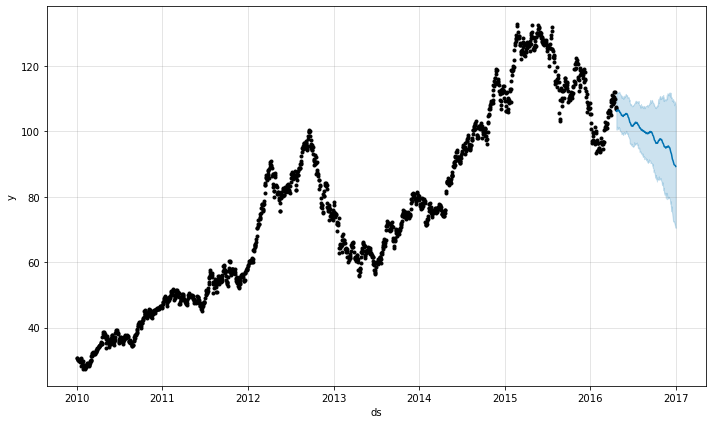

In [13]:
# We need to rename the columns in order for Prophet to understand the data
prophet_data = stock_df_date_close.copy(deep=False)
prophet_data.columns = ['ds','y']

train, init_test = train_test_split(prophet_data, test_size=0.1, shuffle = False)

# Select only the dates for the test-set
test = pd.DataFrame(init_test['ds'])

# Start training the model with the testdata
model = Prophet(daily_seasonality=False)
model.fit(train)

# make a prediction with the testdata
prophet_prediction = model.predict(test)

model.plot(prophet_prediction);

This graph shows a trend estimate of the prophet model. If we compare this graph with the actual price trend of the underlying stock, we can see that the actual value did not fall as much as the model predicted. It followed a downward trend, while the actual stock price stagnated/increased and did not fall as predicted.


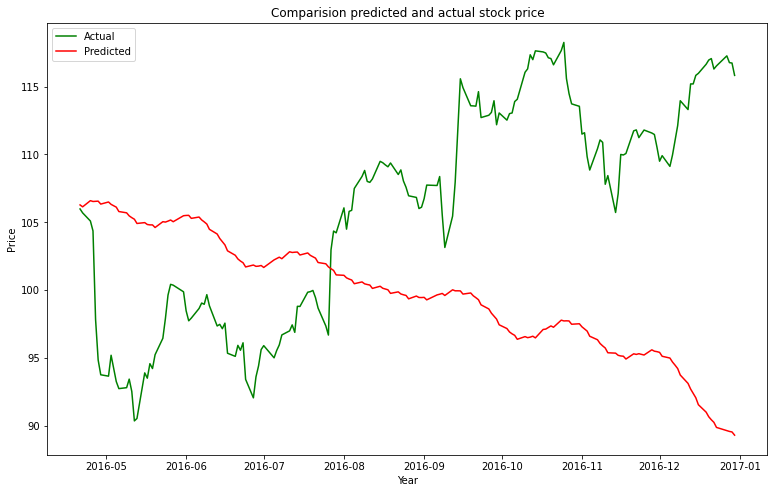

MSE: 178.044


In [50]:
actual_data, prediction_data = predict_prophet(prophet_data, 177)

plot_comparison_graph("Comparision predicted and actual stock price",
                      actual_data['ds'], 
                      actual_data['y'],
                      prediction_data['ds'],
                      prediction_data['yhat']
                     )

# calc MAE expected and predicted values
mse = mean_squared_error(actual_data['y'], prediction_data['yhat'])
print('MSE: %.3f' % mse)

To analyze the prediction, we will focus on a 31-day prediction in the next example. Here we will calculate the MSE and plot the difference between the actual and predicted stock chart for this specific time frame.

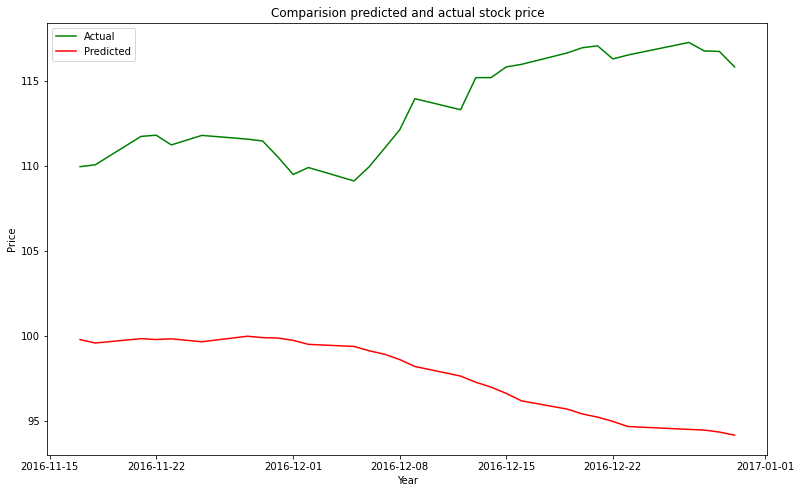

MSE: 270.469


In [49]:
actual_data, prediction_data = predict_prophet(prophet_data, 30)

plot_comparison_graph("Comparision predicted and actual stock price",
                      actual_data['ds'], 
                      actual_data['y'],
                      prediction_data['ds'],
                      prediction_data['yhat']
                     )

# calc MAE expected and predicted values
mse_prophet = mean_squared_error(actual_data['y'], prediction_data['yhat'])
print('MSE: %.3f' % mse_prophet)

# 9. Recurrent Neural Network

In this section, we will train different Recurrent Neural Network using the data and finally compare them in the summary.

  * Gated Recurrent Unit (GRU)
  * Long short-term memory (LSTM)
      * One Layer LSTM
      * Multi Layer LSTM
      * Multi Layer LSTM with multiple Data Columns
      
      
All neural networks use 90 timesteps of the past to predict 30 timesteps into the future. Since the data were divided accordingly, one timestep represents one trading day on the stock exchange. Chapter 9.1 contains reusable methods like prepare_rnn_data, which is used to put the dataset into a format that is understandable for the neural network. this can also be used to add additional columns of the original dataset for evaluation.

## 9.1 Reusable functions

In [88]:
def prepare_rnn_data(dataframe, column_count, split_factor):
    # Split the data into training and test and extract the close columns values
    lstm_train = dataframe
    lstm_train_data = lstm_train.iloc[:, 1:column_count+1].values

    split_count = int((split_factor * int(len(lstm_train_data))))

    # Scale the values with MinMaxScaler
    scaler = MinMaxScaler(feature_range = (0,1))

    # Step-Size - 1 for every day
    step = 1

    # Use the last 90 market days to predict 30 days of future
    past = 90
    future = 30
    batch_size = 1

    # Normalize the Train Data
    lstm_train_scaled_complete = scaler.fit_transform(lstm_train_data)
    lstm_train_scaled_complete = pd.DataFrame(lstm_train_scaled_complete)

    # Split Train data into Train/Validation
    lstm_train_scaled_train = lstm_train_scaled_complete.loc[0:split_count-1]
    lstm_train_scaled_validation = lstm_train_scaled_complete.loc[split_count:]

    start = past + future
    end = start + split_count
    sequence_length = int(past / step)   


    x_train = lstm_train_scaled_train[[i for i in range(column_count)]].values
    y_train = lstm_train_scaled_complete.iloc[start:end][[0]]

    # Train dataset
    dataset_train = keras.preprocessing.timeseries_dataset_from_array(
        x_train,
        y_train,
        sequence_length=sequence_length,
        sampling_rate=step,
        batch_size=batch_size,
    )

    # Validation Dataset
    x_end = len(lstm_train_scaled_validation) - past - future

    label_start = split_count + past + future

    x_val = lstm_train_scaled_validation.iloc[:x_end][[i for i in range(column_count)]].values
    y_val = lstm_train_scaled_complete.iloc[label_start:][[0]]

    dataset_val = keras.preprocessing.timeseries_dataset_from_array(
        x_val,
        y_val,
        sequence_length=sequence_length,
        sampling_rate=step,
        batch_size=batch_size,
    )
    
    return dataset_train, dataset_val, scaler

def predict_and_plot_forecast_lstm(dataset_val, model, scaler):
    # Take the last Timestep to predict 30 days into the future
    for x, y in dataset_val.skip(len(dataset_val)-1):
        prediction = model.predict(x)[0]
        prediction = np.reshape(prediction,(-1,1))
        prediction_inverse = scaler.inverse_transform(prediction)
        actual_value = np.reshape(y,(-1,1))
        actual_value = scaler.inverse_transform(actual_value)
        history = np.reshape(x,(-1,1))
        history = scaler.inverse_transform(history)
        show_comparison_plot(
            [history, actual_value, prediction_inverse],
            30,
            "Predict 30 Days into the Future",
        )
        mse = mean_squared_error(actual_value, prediction_inverse)
        print('MSE: %.3f' % mse)
        return mse

def predict_and_plot_multicolumn_forecast_lstm(dataset_val, model, scaler):
    # Adjust scaler
    newScaler = MinMaxScaler()
    newScaler.min_,newScaler.scale_ = scaler.min_[0],scaler.scale_[0]
    mse_collector = 0.0
    mse_array = []
    
    # Predict 30 days total to get an average error
    for x, y in dataset_val:
        prediction = model.predict(x)[0]
        prediction = np.reshape(prediction,(-1,1))
        prediction_inverse = newScaler.inverse_transform(prediction)[:, [0]]
        actual_value = np.reshape(y,(-1,1))
        actual_value = newScaler.inverse_transform(actual_value)[:, [0]]
        tmp_mse = mean_squared_error(actual_value, prediction_inverse)
        mse_array.append(tmp_mse)
        mse_collector += tmp_mse
    
    # Take the last Timestep to predict 30 days into the future
    for x, y in dataset_val.skip(len(dataset_val)-1):
        prediction = model.predict(x)[0]
        prediction = np.reshape(prediction,(-1,1))
        prediction_inverse = newScaler.inverse_transform(prediction)[:, [0]]
        actual_value = np.reshape(y,(-1,1))
        actual_value = newScaler.inverse_transform(actual_value)[:, [0]]
        history = np.reshape(x,(-1,5))
        history = newScaler.inverse_transform(history)[:, [0]]
        show_comparison_plot(
            [history, actual_value[0], prediction_inverse[0]],
            30,
            "Predict 30 Days into the Future",
        )
        mse = mean_squared_error(actual_value, prediction_inverse)
        print('MSE: %.3f' % mse)
        mse_average = mse_collector / len(dataset_val)
        return mse, mse_average, mse_array

## 9.2 Simple Recurrent Neural Network
SimpleRNN is a Fully-connected RNN where the output is to be fed back to input.
The Dataset used to train this model is based on the close price of the specific day. We predict the 30th day into the future on all following models. The dataset is split into training and validation date with a ratio of 0.8. So 80% of the data will be used to train the model while 20% is used to validate the training.

In [17]:
dataset_train, dataset_val, scaler = prepare_rnn_data(stock_df_date_close, 1, 0.8)

learning_rate = 0.001
epochs = 10

for batch in dataset_train.take(1):
    inputs, targets = batch

model = keras.Sequential()

# 1 Layer
model.add(SimpleRNN(32, input_shape = (inputs.shape[1], inputs.shape[2]), recurrent_dropout=0.5, dropout=0.5))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop', loss='mean_squared_error')

# Compile
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, 32)                1088      
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 1,121
Trainable params: 1,121
Non-trainable params: 0
_________________________________________________________________


In [18]:
history = model.fit(dataset_train,epochs=epochs,validation_data=dataset_val)

Epoch 1/10
1320/1320 [==============================] - 10s 7ms/step - loss: 0.0699 - val_loss: 0.0091
Epoch 2/10
1320/1320 [==============================] - 9s 7ms/step - loss: 0.0642 - val_loss: 0.0035
Epoch 3/10
1320/1320 [==============================] - 10s 7ms/step - loss: 0.0546 - val_loss: 0.0062
Epoch 4/10
1320/1320 [==============================] - 9s 7ms/step - loss: 0.0467 - val_loss: 0.0398
Epoch 5/10
1320/1320 [==============================] - 9s 7ms/step - loss: 0.0478 - val_loss: 0.0436
Epoch 6/10
1320/1320 [==============================] - 10s 7ms/step - loss: 0.0394 - val_loss: 0.0330
Epoch 7/10
1320/1320 [==============================] - 9s 7ms/step - loss: 0.0235 - val_loss: 0.0244
Epoch 8/10
1320/1320 [==============================] - 10s 7ms/step - loss: 0.0154 - val_loss: 0.0207
Epoch 9/10
1320/1320 [==============================] - 9s 7ms/step - loss: 0.0127 - val_loss: 0.0200
Epoch 10/10
1320/1320 [==============================] - 9s 7ms/step - loss: 0

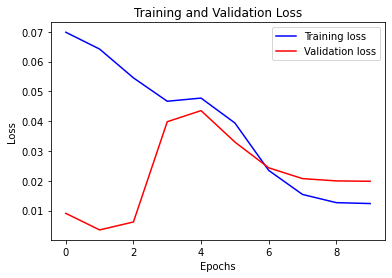

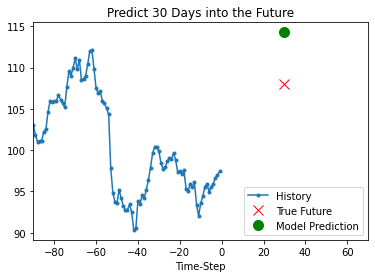

MSE: 39.182


In [19]:
visualize_loss(history, "Training and Validation Loss")
srnn_mse = predict_and_plot_forecast_lstm(dataset_val, model, scaler)

## 9.3 Gated Recurrent Unit (GRU)

In [20]:
dataset_train, dataset_val, scaler = prepare_rnn_data(stock_df_date_close, 1, 0.8)

learning_rate = 0.001
epochs = 10

for batch in dataset_train.take(1):
    inputs, targets = batch

model = keras.Sequential()

# 1 Layer
model.add(GRU(32, input_shape = (inputs.shape[1], inputs.shape[2]), recurrent_dropout=0.5, dropout=0.5))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop', loss='mean_squared_error')

# Compile
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 32)                3360      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 3,393
Trainable params: 3,393
Non-trainable params: 0
_________________________________________________________________


In [21]:
history = model.fit(dataset_train,epochs=epochs,validation_data=dataset_val)

Epoch 1/10
1320/1320 [==============================] - 36s 28ms/step - loss: 0.0029 - val_loss: 0.0224
Epoch 2/10
1320/1320 [==============================] - 36s 27ms/step - loss: 0.0102 - val_loss: 0.0221
Epoch 3/10
1320/1320 [==============================] - 36s 27ms/step - loss: 0.0073 - val_loss: 0.0217
Epoch 4/10
1320/1320 [==============================] - 36s 27ms/step - loss: 0.0064 - val_loss: 0.0219
Epoch 5/10
1320/1320 [==============================] - 36s 27ms/step - loss: 0.0067 - val_loss: 0.0226
Epoch 6/10
1320/1320 [==============================] - 36s 28ms/step - loss: 0.0061 - val_loss: 0.0209
Epoch 7/10
1320/1320 [==============================] - 36s 27ms/step - loss: 0.0056 - val_loss: 0.0223
Epoch 8/10
1320/1320 [==============================] - 36s 28ms/step - loss: 0.0057 - val_loss: 0.0197
Epoch 9/10
1320/1320 [==============================] - 36s 27ms/step - loss: 0.0046 - val_loss: 0.0200
Epoch 10/10
1320/1320 [==============================] - 36s 27m

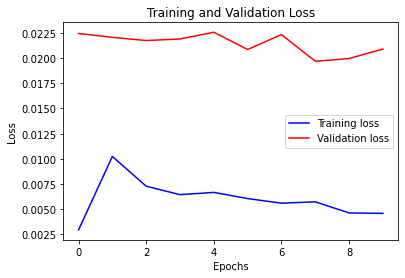

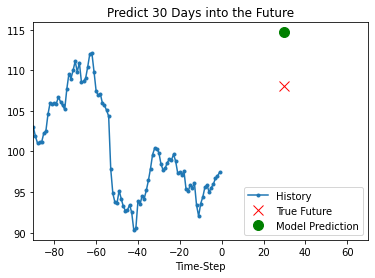

MSE: 44.360


In [22]:
visualize_loss(history, "Training and Validation Loss")
gru_mse = predict_and_plot_forecast_lstm(dataset_val, model, scaler)

## 9.4 Long short-term memory (LSTM)

In the following, we use an LSTM to predict the stock price. For this, we try three different neural network setups and will compare their performance later in the summary.

### 9.4.1 One Layer LSTM
A simple LSTM with one column. It uses the close prices of the last 90 days to predict 30 days into the future.
For this setup we will use the close price of every day only. After we compared this basic approach we will try and add all columns to the LSTM to compare the perfomrance against the basic LSTM that uses only one column. In addition, this model uses only one LSTM layer and no dropout layer for training/prediction.

In [23]:
dataset_train, dataset_val, scaler = prepare_rnn_data(stock_df_date_close, 1, 0.8)

learning_rate = 0.001
epochs = 5

for batch in dataset_train.take(1):
    inputs, targets = batch

model = keras.Sequential()

# 1 Layer
model.add(LSTM(units=32, input_shape = (inputs.shape[1], inputs.shape[2])))

# Output Layer
model.add(Dense(units = 1))

# Compile
model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate), loss="mean_squared_error")
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 32)                4352      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 4,385
Trainable params: 4,385
Non-trainable params: 0
_________________________________________________________________


In [24]:
# Fitting the neural network to the training set
history = model.fit(dataset_train,epochs=epochs,validation_data=dataset_val)

Epoch 1/5
1320/1320 [==============================] - 14s 11ms/step - loss: 0.0010 - val_loss: 0.0087
Epoch 2/5
1320/1320 [==============================] - 14s 11ms/step - loss: 0.0015 - val_loss: 0.0076
Epoch 3/5
1320/1320 [==============================] - 14s 11ms/step - loss: 0.0018 - val_loss: 0.0065
Epoch 4/5
1320/1320 [==============================] - 14s 11ms/step - loss: 0.0020 - val_loss: 0.0056
Epoch 5/5
1320/1320 [==============================] - 14s 11ms/step - loss: 0.0022 - val_loss: 0.0052


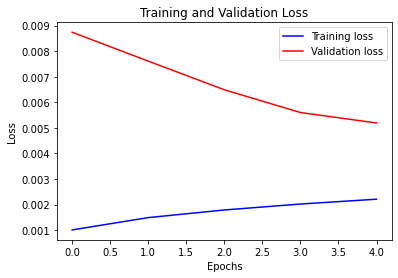

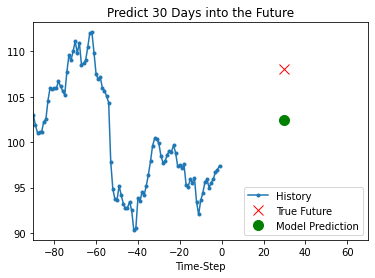

MSE: 31.156


In [25]:
visualize_loss(history, "Training and Validation Loss")
one_layer_lstm_mse = predict_and_plot_forecast_lstm(dataset_val, model, scaler)

### 9.4.2 Multi Layer LSTM
The following setup consists of 3 LSTM layers and 3 dropout layers with a value of 0.5.
Here we want to find out how the additional layers and the dropout condition can improve the predictions.

In [26]:
dataset_train, dataset_val, scaler = prepare_rnn_data(stock_df_date_close, 1, 0.8)

learning_rate = 0.001
epochs = 5

for batch in dataset_train.take(1):
    inputs, targets = batch

model = keras.Sequential()

# 1 Layer
model.add(LSTM(units=32, return_sequences=True, input_shape = (inputs.shape[1], inputs.shape[2])))
model.add(Dropout(0.5))

# 2 Layer
model.add(LSTM(units=32, return_sequences=True))
model.add(Dropout(0.5))

# 3 Layer
model.add(LSTM(units=32))
model.add(Dropout(0.5))

# Output Layer
model.add(Dense(units = 1))

# Compile
model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate), loss="mean_squared_error")

# Fitting the neural network to the training set
history_complex = model.fit(dataset_train,epochs=epochs,validation_data=dataset_val)

Epoch 1/5
1320/1320 [==============================] - 45s 34ms/step - loss: 0.0074 - val_loss: 0.0047
Epoch 2/5
1320/1320 [==============================] - 43s 33ms/step - loss: 0.0073 - val_loss: 0.0078
Epoch 3/5
1320/1320 [==============================] - 43s 33ms/step - loss: 0.0082 - val_loss: 0.0145
Epoch 4/5
1320/1320 [==============================] - 43s 33ms/step - loss: 0.0106 - val_loss: 0.0080
Epoch 5/5
1320/1320 [==============================] - 43s 33ms/step - loss: 0.0104 - val_loss: 0.0094


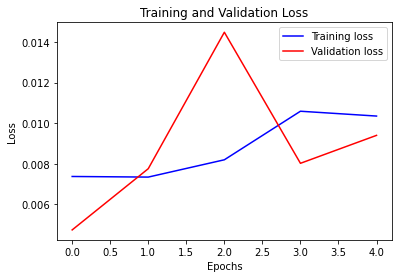

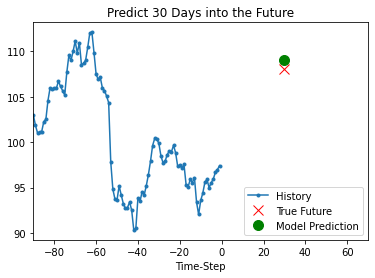

MSE: 1.018


In [27]:
visualize_loss(history_complex, "Training and Validation Loss")
multi_layer_lstm_mse = predict_and_plot_forecast_lstm(dataset_val, model, scaler)

### 9.4.3 Multi Layer LSTM with multiple Data Columns
The last setup uses the same structure as before. In addition, however, all further data columns of the original data set are now included and trained. The prediction, however, remains the same and we will predict the 30th day.

In [28]:
print(stock_df_complete.head())

           date      close       open        low       high       volume
254  2010-01-04  30.572857  30.490000  30.340000  30.642857  123432400.0
721  2010-01-05  30.625713  30.657143  30.464285  30.798571  150476200.0
1189 2010-01-06  30.138571  30.625713  30.107143  30.747143  138040000.0
1657 2010-01-07  30.082857  30.250000  29.864286  30.285715  119282800.0
2125 2010-01-08  30.282858  30.042856  29.865715  30.285715  111902700.0


In [29]:
dataset_train, dataset_val, scaler = prepare_rnn_data(stock_df_complete, 5, 0.8)

learning_rate = 0.001
epochs = 5

for batch in dataset_train.take(1):
    inputs, targets = batch

model = keras.Sequential()

# 1 Layer
model.add(LSTM(units=32, return_sequences=True, input_shape = (inputs.shape[1], inputs.shape[2])))
model.add(Dropout(0.5))

# 2 Layer
model.add(LSTM(units=32, return_sequences=True))
model.add(Dropout(0.5))

# 3 Layer
model.add(LSTM(units=32))
model.add(Dropout(0.5))

# Output Layer
model.add(Dense(units = 1))

# Compile
model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate), loss="mean_squared_error")

# Fitting the neural network to the training set
history_complex_multi_column = model.fit(dataset_train,epochs=epochs,validation_data=dataset_val)

Epoch 1/5
1320/1320 [==============================] - 45s 34ms/step - loss: 0.0074 - val_loss: 0.0177
Epoch 2/5
1320/1320 [==============================] - 43s 33ms/step - loss: 0.0082 - val_loss: 0.0086
Epoch 3/5
1320/1320 [==============================] - 43s 33ms/step - loss: 0.0086 - val_loss: 0.0064
Epoch 4/5
1320/1320 [==============================] - 43s 33ms/step - loss: 0.0078 - val_loss: 0.0075
Epoch 5/5
1320/1320 [==============================] - 43s 33ms/step - loss: 0.0072 - val_loss: 0.0068


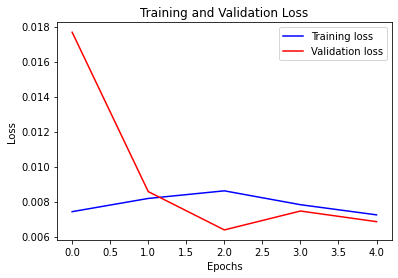

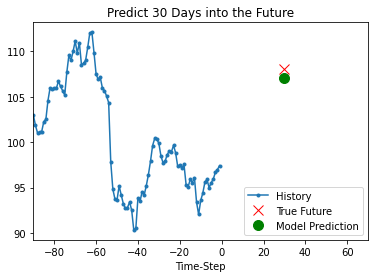

MSE: 0.932


In [89]:
visualize_loss(history_complex_multi_column, "Training and Validation Loss")
multi_layer_column_lstm_mse, multi_layer_column_lstm_mse_average, multi_layer_column_lstm_mse_array = predict_and_plot_multicolumn_forecast_lstm(dataset_val, model, scaler)

# 10. Summary

Finally, we look at the error rates of all the variants we performed based on the prediction of the 30th day in the future.

In [86]:
mse_result = []
mse_result.append(["SES Training with complete Dataset", mse_sse_complete])
mse_result.append(["SES Training with small Dataset", mse_sse_partly])
mse_result.append(["Facebook Prophet", mse_prophet])
mse_result.append(["Simple Recurrent Neural Network", srnn_mse])
mse_result.append(["Gated Recurrent Unit (GRU)", gru_mse])
mse_result.append(["One Layer LSTM", one_layer_lstm_mse])
mse_result.append(["Multi Layer LSTM", multi_layer_lstm_mse])
mse_result.append(["Multi Layer LSTM with multiple Data Columns", multi_layer_column_lstm_mse])
mse_df = pd.DataFrame(mse_result, columns=["Name", "Mean Squared Error"])
mse_df

76.32498843307607


,Name,Mean Squared Error
0,SES Training with complete Dataset,19.012297
1,SES Training with small Dataset,20.141658
2,Facebook Prophet,270.468770
3,Simple Recurrent Neural Network,39.181606
4,Gated Recurrent Unit (GRU),44.360117
5,One Layer LSTM,31.156179
6,Multi Layer LSTM,1.018024
7,Multi Layer LSTM with multiple Data Columns,0.932190


Both variants of Simple Exponential Smoothing have a significant deviation in the prediction. Unexpectedly, with a much smaller data set, i.e. less historical data, the forecast was still somewhat worse.

Nevertheless, the prediction of Prophet reached a significantly worse value. The trend direction predicted by the model was contrary to the actual trendline of the share price. In itself, Prophet is practical for predicting trends and seasonally recurring events, but it cannot be applied very successfully to the price trend of a stock.

The first two models in the framework of Recurrent Neural Networks could not produce superior predictions even after some optimization with dropout layers. The Simple Recurrent Neural Network and Gated Recurrent Unit are close in performance.

With a LSTM with one layer, the mean squared error value was further reduced. Since this model was constructed with only one layer and no dropout was defined, the result was already more promising. 
First, a total of 3 layers and 3 dropout layers were added and the model was trained again. This resulted in a strong improvement of the error rate and gave us the lowest value so far.

Finally, we took this improved LSTM model and added more columns as additional information to see the impact on the predictions. Again, this change has led to another small improvement in the prediction and we have achieved our smallest and thus most accurate error value.

It is important to note that the predictions in this context of the evaluation are only a single date in the future. It is not guaranteed that all days can be predicted by the different models with the same error rate.

The following figure shows the result of 144 predictions of the model. The mean squared error value of each individual prediction is shown. As you can see, there are a lot of swings with very inaccurate predictions, but also some good predictions.

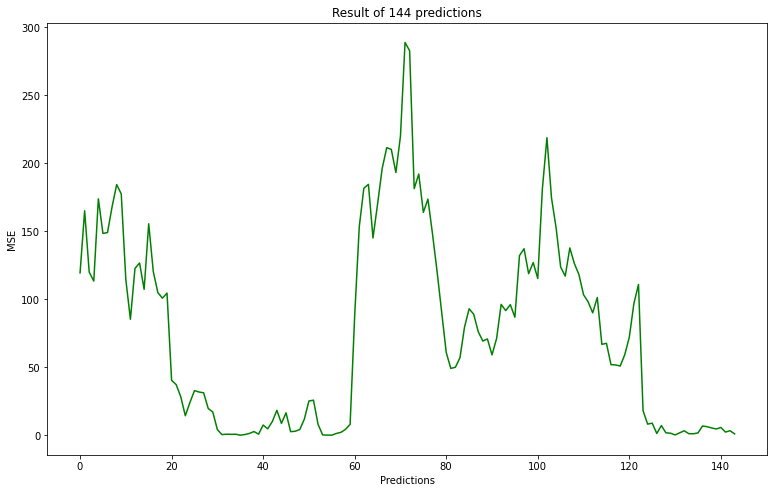

In [106]:
multi_layer_column_lstm_mse_array_df = pd.DataFrame(multi_layer_column_lstm_mse_array)
multi_layer_column_lstm_mse_array_df.columns = ["mse"]

fig = plt.figure(figsize = (10,6))
ax1 = fig.add_axes([0,0,1,1])
ax1.plot(multi_layer_column_lstm_mse_array_df, color='green')
ax1.set_ylabel('MSE')
ax1.set_xlabel('Predictions')
plt.title("Result of 144 predictions")
plt.show()

In [109]:
good_predictions_df = multi_layer_column_lstm_mse_array_df[multi_layer_column_lstm_mse_array_df["mse"] <= 5].copy(deep=False)
bad_predictions_df = multi_layer_column_lstm_mse_array_df[multi_layer_column_lstm_mse_array_df["mse"] > 5].copy(deep=False)

percentage_good = (len(good_predictions_df) * 100) / len(multi_layer_column_lstm_mse_array_df)
percentage_bad = (len(bad_predictions_df) * 100) / len(multi_layer_column_lstm_mse_array_df)
print("Gute Vorhersagen:", percentage_good, "%")
print("Schlechte Vorhersagen:", percentage_bad, "%")

Gute Vorhersagen: 22.916666666666668 %
Schlechte Vorhersagen: 77.08333333333333 %


If we consider an mse of at most 5 to be good, then the model generates around ~23% good predictions and ~77% bad predictions.

# 11. Conclusion

As we have seen, a neural network is able to make some good predictions. The big problem here, however, is that the system is not very reliable in making good predictions. We think that a LSTM with multiple layers and lots of data is the most extensible and performed best in our experiment. However, stock prices are not easily predicted from their historical data. There are too many external factors, such as politics, economy, trends and many others that influence the stock price. 

Since share prices usually represent the future value of a company and not its past value, it becomes even more difficult to construct a system that can make more accurate predictions without including a lot of external data. Thus, we would almost argue that since neural networks are based on past data, they are not well suited for more accurate prediction. Instead, systems would need to incorporate many other factors and the general mood of the stock market, the economy and politics into the prediction. In other words, more live data than historical data.